### Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#official libraries
import numpy as np
import matplotlib.pyplot as plt
import pylab
import cmath
import random
from scipy import integrate
from scipy.fftpack import fft
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy import signal
import pandas as pd
import time
import torch.nn as nn
import torch.nn.functional as F
import visdom
from os.path import expanduser

In [3]:
#own files
from lib.utils_general import diff_same_length, get_data_paths
from lib.utils_generate_W import get_grid, gauss_dist, generate_W
from lib.utils_generate_n import n_compl, plot_n
from lib.utils_calc_psi import plot_psi
from lib.utils_generate_data import generate_init_data, \
                                    generate_init_data_diverse, \
                                    plot_sample, generate_corr_data
from lib.utils_initial_dataset import InitialDataset, ToTensor, OneChannel, \
                                      Normalize, calc_mean_std
from lib.utils_train import get_dataloaders, train_net, calc_psi_Int
from lib.nets import FNN, UNet, ResSNN
from lib.utils_evaluation import DeNorm, plot_prediction, plot_correction
from lib.utils_corrector_dataset import CorrectorDataset, NormalizeCorr, \
                                        calc_mean_std_corr, ToDevice
from lib.utils_train_corrector import train_corrector
from lib.UNet_featurek import UNet_featurek
from lib.LSTM import LSTM
from lib.plot_intensity_bars import plot_intensity_bars
from lib.LSTMFFout import LSTMFFout
from lib.utils_stack_model_psisolver import train_lstm, \
            train_psisolver, get_psi, stack_init_visdom, \
            stack_visdom_point, PsiSolver
from lib.utils_stack_model_corrector import corrector_init_visdom, \
        corrector_train, corrector_visdom_point

In [4]:
torch.cuda.is_available()

True

### Parameter, paths, etc

In [16]:
# ---------------------------------
# choose which mode the prg is in:
# ---------------------------------
do_create_test_data = False
which_model = 'stack_model_corrector'  #FNN / UNet / UNet_old / UNet_featurek /
#LSTM / LSTMFFout / CIWLSTM / stack_model_psisolv / ResSNN / stack_model_corrector
#which_model_corr = 'UNet'
toy_data = False
# ---------------------------------

# ---------------------------------
# paths:
# ---------------------------------
home = expanduser("~")

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# models
path_model = 'models/' + which_model + '.pt'
path_psisolver = 'models/' + which_model + '_psisolver.pt'
path_corrector = 'models/' + which_model + '_corrector.pt'

# data
path_initial_data, path_corrector_data = get_data_paths(toy_data, 
                                                        device, 
                                                        home)

path_initial_data_diverse = home + '/ml_data/data_initial_diverse/'
path_test_data = home + '/ml_data/data_test/'

# plots
path_plots = 'plots/'
# ---------------------------------

# ---------------------------------
# hyperparameters:
# ---------------------------------
validation_split = 0.2
# ---------------------------------

# ---------------------------------
# data parameters:
# ---------------------------------
half_width = 5
nmbr_points = 10000
#if toy_data:
#    size_dataset = 8  #if run on GPU machine, set to 5000 (toydata 8)
#else:
size_dataset = 3000

grid, stepsize = get_grid(half_width, nmbr_points)
# ---------------------------------

### Create Initial Dataset and -loader

In [17]:
if do_create_test_data:
    generate_init_data_diverse(1000, path=path_test_data, x=grid, dx=stepsize)

In [18]:
nr_mean_test, nr_std_test, ni_mean_test, ni_std_test = calc_mean_std(
    3000, path_test_data)

In [19]:
transform_test = transforms.Compose([
    Normalize((nr_mean_test, ni_mean_test), (nr_std_test, ni_std_test)),
    ToTensor() #device
])

In [20]:
initial_dataset_test = InitialDataset(csv_file=path_test_data + 'k_values.csv',
                                      root_dir=path_test_data,
                                      transform=transform_test)

In [21]:
len(initial_dataset_test)

3000

tensor([-1.0156, -1.0156, -1.0156,  ..., -1.0156, -1.0156, -1.0156])
torch.Size([10001])
k:  1.000000015368065


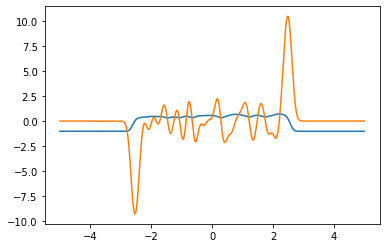

In [22]:
#show that it worked
idx = np.random.randint(len(initial_dataset_test))

print(initial_dataset_test[idx]['k_n_r'])
print(initial_dataset_test[idx]['k_n_r'].size())
#print(initial_dataset[idx]['k_n_r'].is_cuda)

print('k: ',
      DeNorm(initial_dataset_test[idx]['k_n_r'].cpu().numpy()[0], nr_mean_test, nr_std_test))

plt.plot(grid, initial_dataset_test[idx]['k_n_r'].cpu().numpy()[1:])
plt.plot(grid, initial_dataset_test[idx]['n_i'].cpu().numpy())

In [23]:
test_loader, _ = get_dataloaders(initial_dataset_test,
                                 batch_size=6,
                                 validation_split=0,
                                 shuffle_dataset=False,
                                 random_seed=42)

### Load Model

In [24]:
model = torch.load(path_model,
                       map_location=device)  # , map_location=device

if which_model == 'stack_model_corrector':
    corrector = torch.load(path_corrector, 
                           map_location=device)

print(model)
if which_model == 'stack_model_psisolver':
    print(psisolver)
elif which_model == 'stack_model_corrector':
    print(corrector)

LSTMFFout(
  (lstm): LSTM(11, 100, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=100, out_features=10, bias=True)
  (fc2): Linear(in_features=10001, out_features=10000, bias=True)
)
LSTMFFout(
  (lstm): LSTM(11, 100, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=100, out_features=10, bias=True)
  (fc2): Linear(in_features=10001, out_features=10000, bias=True)
)


In [25]:
model.to(device)
print(next(model.parameters()).is_cuda)
if which_model == 'stack_model_psisolver':
    psisolver.to(device)
    print(next(psisolver.parameters()).is_cuda)
elif which_model == 'stack_model_corrector':
    corrector.to(device)
    print(next(corrector.parameters()).is_cuda)

True
True


### Evaluation

In [61]:
def stacked_model(model, corrector, grid, stepsize, k_n_r, nr_mean, nr_std, ni_mean, ni_std, device):
    
    ni_pred = model(k_n_r)
    
    _, _, Int = get_psi(grid,
                         stepsize,
                         DeNorm(k_n_r, nr_mean, nr_std),
                         DeNorm(ni_pred, ni_mean, ni_std),
                         Amp=1)
    Int = Int.to(device)
    
    corrector_input = torch.cat((k_n_r[:,0].view(-1,1), Int),dim=1)
            
    ni_diff_pred = model(corrector_input)
    
    return DeNorm(ni_pred.cpu().detach().numpy(), ni_mean, ni_std), \
           ni_diff_pred.cpu().detach().numpy(), \
           DeNorm(k_n_r[:,0].cpu().detach().numpy(), nr_mean, nr_std)

In [40]:
plt.rcParams['figure.figsize'] = [15, 10]

In [41]:
model.eval()
if which_model == 'stack_model_corrector':
    corrector.eval()

The prediction looks like this...

torch.Size([6, 10000])
7.0
[[ 1.00468300e-01 -3.77383083e-01  2.58182436e-02 ...  5.96151240e-02
   2.33958717e-02  6.18188381e-02]
 [ 1.03619538e-01 -3.77632141e-01  2.83070169e-02 ...  6.00779653e-02
   2.34590434e-02  6.01701960e-02]
 [ 7.11799320e-03 -1.07260779e-01  1.45202354e-02 ... -6.59783836e-05
   3.60176116e-02  1.59250759e-02]
 [ 2.69735381e-02 -1.96207538e-01  2.26306301e-02 ...  1.51456995e-02
   5.31636551e-02  2.86035109e-02]
 [ 6.52611256e-03 -9.23433080e-02  1.57780033e-02 ... -3.60678369e-03
   3.12623307e-02  1.47342710e-02]
 [ 1.04075717e-02 -1.13069862e-01  1.60838254e-02 ...  6.03010878e-03
   3.73238362e-02  9.28580761e-03]]
[-1.8189894e-12 -1.8189894e-12 -1.8189894e-12 ... -1.8189894e-12
 -1.8189894e-12 -1.8189894e-12]


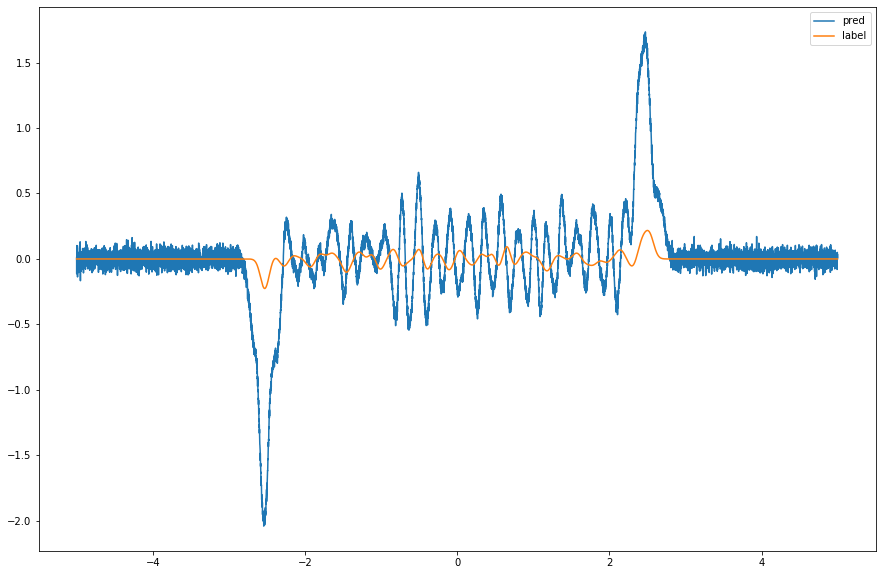

In [69]:
item = next(iter(test_loader))

k_n_r = item['k_n_r'].to(device)
n_i = item['n_i'].to(device)            
            
ni_pred, ni_diff_pred, k = stacked_model(model, corrector, grid, stepsize, k_n_r, nr_mean_test, nr_std_test, ni_mean_test, ni_std_test, device)

#print(ni_pred)
#print(ni_diff_pred)
ni_corr = ni_pred + ni_diff_pred

idx = np.random.randint(len(ni_corr))
print(k[idx])

print(ni_corr)
print(ni)

plt.plot(grid, ni_corr[idx], label = 'pred')
plt.plot(grid, ni, label = 'label')
plt.legend(loc='upper right')
            

# nr, ni, ni_pred, k = plot_prediction(test_loader,
#                                      model,
#                                      grid,
#                                      nr_mean_test,
#                                      nr_std_test,
#                                      ni_mean_test,
#                                      ni_std_test,
#                                      idx=0,
#                                      k=None,
#                                     device = device)
#plt.savefig(path_plots + which_model + '_Prediction.pdf')

The intensity with the label potential like this...

In [ ]:
Int = plot_psi(grid, stepsize, n=nr + 1j * ni, Amp=1, k=k)

And the intensity with the predicted potential like this...

In [ ]:
Int_pred = plot_psi(grid, stepsize, n=nr + 1j * ni_pred, Amp=1, k=k)
#plt.savefig(path_plots + which_model + '_CI.pdf')

The differences between the predicted potentials and intensities like this...

In [ ]:
plt.plot(ni_pred - ni, label='ni diff')
plt.plot(Int_pred - Int, label='Int diff')
plt.legend(loc='upper right')
#plt.savefig(path_plots + which_model + '_Diff.pdf')

The label intensity vs the predicted

In [ ]:
plt.plot(Int - 1, label='Int')
plt.plot(Int_pred - 1, label='Int pred')
plt.legend(loc='upper right')

### Test

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]

In [ ]:
# numerov wave to just nr (what about the intensity? it shouldnt be wave-y)

idx = np.random.randint(8)

item = next(iter(test_loader))

knr = item['k_n_r'].to(device)
print('knr: ', knr.size())
ni_pred = model(knr)[idx]
print('ni_pred: ', ni_pred.size())

nr = knr[idx]
print('nr: ', nr.size())

k = DeNorm(knr[idx][0].cpu().numpy(), nr_mean_test, nr_std_test)
print(k)
n = DeNorm(nr.cpu().numpy(), nr_mean_test, nr_std_test)  # + 1j*ni_pred.detach().numpy()
plot_psi(grid, stepsize, n, Amp=1, k=k, plot=True)

plt.savefig(path_plots + '_onlynr.pdf')

### Test

In [ ]:
idx = np.random.randint(3000)
print(idx)

data = initial_dataset_test[idx]['k_n_r'].view(1, -1).to(device)
out = model(data)
label = initial_dataset_test[idx]['n_i'].to(device)

criterion = torch.nn.MSELoss()
print(criterion(out[0], label).item() * 8)

plt.plot(grid,
         DeNorm(data[0][1:].detach().cpu().numpy(), nr_mean_test, nr_std_test),
         label='nr')
plt.plot(grid,
         DeNorm(out[0].detach().cpu().numpy(), ni_mean_test, ni_std_test),
         label='ni_pred')
plt.plot(grid,
         DeNorm(label.detach().cpu().numpy(), ni_mean_test, ni_std_test),
         label='ni_label')
plt.legend(loc='upper left')
plt.show

In [ ]:
# predict ni for other k - does that work...?

idx = np.random.randint(6)
print('idx: ', idx)

item = next(iter(test_loader))

knr = item['k_n_r'].to(device)
print('knr: ', knr)

ni = DeNorm(item['n_i'][idx].detach().cpu().numpy(), ni_mean_test, ni_std_test)
k_real = DeNorm(knr[idx][0].detach().cpu().numpy(), nr_mean_test, nr_std_test)
print('real k: ', k_real)

k_new = 1  #np.random.randint(1,11) # np.around(k_real)
print('new k: ', k_new)

knr[:, 0] = (k_new - nr_mean_test) / nr_std_test  # normalize
print('knr: ', knr)

ni_pred = model(knr)[idx]
#print('ni_pred: ', ni_pred.size())

#print('new k normalized: ',knr[idx][0].cpu().numpy())
k = knr[idx][0].cpu().numpy()
#print('new k: ', k*nr_std + nr_mean)
nr = DeNorm(knr[idx].cpu().numpy(), nr_mean_test, nr_std_test)[1:]
ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test, ni_std_test)
n = nr + 1j * ni_pred
Int_pred = plot_psi(grid, stepsize, n, Amp=1, k=k_new, plot=True)
#Int_pred = plot_psi(grid, stepsize, n, Amp=1, k=k_real, plot = True)
#plt.plot(grid, ni_pred, label='ni')
plt.plot(grid, ni, label='ni label')
plt.legend(loc='upper left')

plt.savefig(path_plots + which_model + '_differentk.pdf')

print('max Int: ', np.max(Int_pred))
print('min Int: ', np.min(Int_pred))

### Treshold CI Check

In [ ]:
# check for all in testset deviation without ni

Amp = 1
hermit_mean_refl_dev = np.zeros(10)  #tresh, k_real
hermit_mean_max_dev = np.zeros(10)
hermit_how_many_k = np.zeros(10)

for j, batch in enumerate(test_loader):

    knrs = batch['k_n_r'].to(device)
    nis = batch['n_i'].to(device)
    for knr, ni in zip(knrs, nis):
        k = int(
            np.around(
                DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test,
                       nr_std_test)))

        hermit_how_many_k[k - 1] += 1

        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)

        Int = plot_psi(grid, stepsize, n=nr, Amp=Amp, k=k, plot=False)

        rel_err_refl = np.max((np.abs(Int[-2000:] - Amp) / Amp)) # only reflections
        rel_err = np.max((np.abs(Int - Amp) / Amp))  # all of it

        hermit_mean_refl_dev[k - 1] += rel_err_refl
        hermit_mean_max_dev[k - 1] += rel_err
        
    if j % 10 == 0:
        print('{}/{}'.format(j, len(test_loader))
              
hermit_mean_refl_dev = hermit_mean_refl_dev / hermit_how_many_k
hermit_mean_max_dev = hermit_mean_max_dev / hermit_how_many_k

In [ ]:
plot_intensity_bars(list(range(1,11)), hermit_mean_max_dev,
                    path_plots + 'bars_hermitean_dev_max.pdf')
plot_intensity_bars(list(range(1,11)), hermit_mean_refl_dev,
                    path_plots + 'bars_hermitean_dev_refl.pdf')

In [ ]:
# check for all in testset deviation with ni label

Amp = 1
nilabel_mean_max_dev = np.zeros(10)
nilabel_how_many_k = np.zeros(10)

for j, batch in enumerate(test_loader):

    knrs = batch['k_n_r'].to(device)
    nis = batch['n_i'].to(device)
    for knr, ni in zip(knrs, nis):
        k = int(
            np.around(
                DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test,
                       nr_std_test)))

        nilabel_how_many_k[k - 1] += 1

        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)
        ni = DeNorm(ni.cpu().numpy(), ni_mean_test, ni_std_test)
        
        Int = plot_psi(grid, stepsize, n=nr+1j*ni, Amp=Amp, k=k, plot=False)

        rel_err = np.max((np.abs(Int - Amp) / Amp))  # all of it

        nilabel_mean_max_dev[k - 1] += rel_err
        
    if j % 10 == 0:
        print('{}/{}'.format(j, len(test_loader))
              
nilabel_mean_max_dev = nilabel_mean_max_dev / nilabel_how_many_k

In [ ]:
plot_intensity_bars(list(range(1,11)), nilabel_mean_max_dev,
                    path_plots + 'bars_nilabel_dev_max.pdf')

In [ ]:
# check for all in testset deviation with ni pred

Amp = 1
nipred_mean_max_dev = np.zeros(10)
nipred_how_many_k = np.zeros(10)

for j, batch in enumerate(test_loader):

    knrs = batch['k_n_r'].to(device)
    nis = batch['n_i'].to(device)
    for knr, ni in zip(knrs, nis):
        k = int(
            np.around(
                DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test,
                       nr_std_test)))

        nipred_how_many_k[k - 1] += 1

        ni_pred = model(knr.view(1, -1))[0]     
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)       
        ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test,
                         ni_std_test)

        Int_pred = plot_psi(grid,
                            stepsize,
                            n=nr + 1j * ni_pred,
                            Amp=Amp,
                            k=k,
                            plot=False)

        rel_err = np.max((np.abs(Int_pred - Amp) / Amp))  # all of it

        nipred_mean_max_dev[k - 1] += rel_err
        
    if j % 10 == 0:
        print('{}/{}'.format(j, len(test_loader))
              
nipred_mean_max_dev = nipred_mean_max_dev / nipred_how_many_k

In [ ]:
plot_intensity_bars(list(range(1,11)), nipred_mean_max_dev,
                    path_plots + 'bars_nipred_dev_max.pdf')

In [ ]:
# check for all in testset with random k deviation

Amp = 1
diffk_mean_max_dev = np.zeros([10,10])
diffk_how_many_k = np.zeros([10,10])

for j, batch in enumerate(test_loader):

    knrs = batch['k_n_r'].to(device)
    nis = batch['n_i'].to(device)
    for knr, ni in zip(knrs, nis):
        k = int(
            np.around(
                DeNorm(knr[0].detach().cpu().numpy(), nr_mean_test,
                       nr_std_test)))

        diffk_how_many_k[k_real - 1, k_new - 1] += 1

        ni_pred = model(knr.view(1, -1))[0]     
        
        nr = DeNorm(knr[1:].detach().cpu().numpy(), nr_mean_test, nr_std_test)       
        ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean_test,
                         ni_std_test)

        Int_pred = plot_psi(grid,
                            stepsize,
                            n=nr + 1j * ni_pred,
                            Amp=Amp,
                            k=k,
                            plot=False)

        rel_err = np.max((np.abs(Int_pred - Amp) / Amp))  # all of it

        diffk_mean_max_dev[k_real - 1, k_new - 1] += rel_err
        
    if j % 10 == 0:
        print('{}/{}'.format(j, len(test_loader))
              
diffk_mean_max_dev = diffk_mean_max_dev / diffk_how_many_k

In [ ]:
sum_over_dev = np.zeros(len(diffk_mean_max_dev))
for i in range(len(sum_over_dev)):
    sum_over_dev[i] = int(np.sum(nipred_mean_max_dev[:,i])) # sum over all initial k

plot_intensity_bars(list(range(1,11)), sum_over_dev,
                    path_plots + 'bars_diffk_dev_max.pdf')

In [ ]:
# map for the frequencies

k_real = list(range(1, 11))
k_new = list(range(1, 11))

textcolors = ["black", "white"]
textcolor_tresh = np.max(diffk_mean_max_dev) / 2

fig, ax = plt.subplots()
im = ax.imshow(diffk_mean_max_dev)

# We want to show all ticks...
ax.set_xticks(np.arange(len(k_new)))
ax.set_yticks(np.arange(len(k_real)))
# ... and label them with the respective list entries
ax.set_xticklabels(k_new)
ax.set_yticklabels(k_real)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(k_real)):
    for j in range(len(k_new)):
        text = ax.text(j,
                       i,
                       np.around(diffk_mean_max_dev[i, j], decimals=2),
                       ha="center",
                       va="center",
                       color=textcolors[int(diffk_mean_max_dev[i, j] < textcolor_tresh)])

ax.set_title(
    "Mean of Maximal Deviation from  CI (x...k_new, y...k_real)")
fig.tight_layout()
plt.savefig(path_plots + which_model + '_MeanMaxDev.pdf')
plt.show()

### Reflections

In [ ]:
def R(psi_xmin1, psi_x0, deltax, k):
    return np.abs(psi_xmin1 - psi_x0*np.exp(1j*k*deltax))**2 / np.abs(psi_x0*np.exp(-1j*k*deltax) - psi_xmin1)**2

In [ ]:
def T(psi_xmin1, psi_x0, deltax, k):
    return 0.5*np.sin(k*deltax)**2 / np.abs(psi_x0*np.exp(-1j*k*deltax) - psi_xmin1)**2

In [ ]:
def get_R_T(n, k, grid, stepsize):
    